## Code for paper on Quantization analytical model 

[Fp8 Quantization : Power of Exponent](https://arxiv.org/abs/2208.09225)

In [125]:
import json
import matplotlib.pyplot as plt
import matplotlib as mat
import numpy as np
import pandas as pd
import math
import scipy.special as sc
import copy
import random
%matplotlib inline

In [128]:
#Floating number can be seen as uniform m-bit grid between two consecutive integer powers of two 2**a , 2**a+1
# distance between two grid points in the range 2**a , 2**a+1 2**a-m  (m - mantissa bits)
#  f= (-1) 2**(p-b)* (1 + d1/2 + d2/4 + d3/8+ .... dm/2**m)  - m (number of mantissa points) 
#                                                            - base (2**(e-1) ) 
#                                                            - e (number of exponent bits)

# increasing m mantissa bits increases number of grid points (decimal accuracy)
# increasing e exponent increases dynamic range of values floating point number can represent

## floating point representation definitions
# 1SEXMY    = X bits of Exponent Y bits of mantissa
#  NAN =  exponent = 2**X-1  mantissa = 2**Y-1  (other versions include multiple NAN values with mantissa not zero)
#  Infinity = exponent bits =2**X-1  mantissa bits = 0
# subnormal =  exponent bits= 0 mantissa bits !=0 
# min subnormal =  2**(1-bias)*(0 + 1/2**Y)   Expo
# max subnormal =  2**(1-bias)*(0 + 2**M-1/2**Y)
# min Normal = 2**(1-bias) *( 1 + 2**M-1/2**Y)  Exponent!=0
# max Normal = 2**(2**E -1 - bias) * (2-1/2**Y)

# example (fp8)  E4M3  bias = 2**(4-1) -1 
# Infinity = S 1111 000 
# NAN      = S 1111 111
# min subnormal = S 0000 001 = (2**(1-7))*(0+1/2**3) = 2**(-6)*(2**-3) = 2**-9
# max subnormal = S 0000 111 = (2**(1-7))*(0 + 7/2**3) = (7*(.125))*2**-6 = 2**-6*(0.875)
# min normal = S 0001 000 (2**(1-7))*(1) = +/- 2**-6
# max normal = S 1111 110   = 2**(15 -7) * (1 + 6*(.125)) = 2**8 *(1.75) = 256*1.75 = S 448 

#example (fp6)
#S E3M2  
# INF = not available
# NAN = not available
# Zero = 000 00
# min subnormal = S 000 01 = 2**(1-3)**(0+1/2**2) = 2**-2 *(1/4) = 2**-4 = 1/16 = 0.0625
# max subnormal = S 000 11 = 2**(1-3)**(0 + 3/2**2) = 2**-2 * (0.75) = 0.75/4 =  0.1875
# max normal = S 111 11 = 2**(7-3)*(2-1/4) = 2**4 *(1.750) = S 28
# min Normal = S 001 00 = 2**(1-3)*(1) = 2**-2 = 1/4 = 0.25

class FloatNumber(object):
    def __init__(self,fmt=None):
        super(FloatNumber,self).__init__()
        self.format=fmt

    def get_float_bias(self):
        if self.format in ["e5m2"]:
            return 16
        elif self.format in ["e4m3"]:
            return 8
        elif self.format in ["e3m4"]:
            return 4
        elif self.format in ["e2m5"]:
            return 2
        

    #return number of mantissa bits
    def get_float_mantissa(self):
       if self.format in ["e5m2"]:
            return 2
       elif self.format in ["e4m3"]:
            return 3
       elif self.format in ["e3m4"]:
            return 4
       elif self.format in ["e2m5"]:
            return 5

    def iterate_mantissa(self):
        precision_range = []
        if self.format in ["e5m2"]:
            smallest_number = 2**-self.get_float_mantissa()
            for idx in range(0,pow(2,self.get_float_mantissa()),1):
                value  = 0
                bit_pos  = (idx & 1)
                value  += bit_pos * smallest_number if bit_pos > 0 else 0
                bit_pos = (idx & 2)
                value  += bit_pos * smallest_number if bit_pos > 0 else 0
                precision_range.append(value) 
        elif self.format in ["e4m3"]:
            smallest_number = 2**-self.get_float_mantissa()
            for idx in range(0,pow(2,self.get_float_mantissa()),1):
                value  = 0
                bit_pos = (idx & 1)
                value  += bit_pos * smallest_number if bit_pos > 0 else 0
                bit_pos = (idx & 2)
                value  += pow(2,1) * smallest_number if bit_pos > 0 else 0
                bit_pos = (idx & 4)
                value  += pow(2,2) * smallest_number  if bit_pos > 0 else 0 
                precision_range.append(value) 
        elif self.format in ["e3m4"]:
            smallest_number = 2**-self.get_float_mantissa()
            for idx in range(0,pow(2,self.get_float_mantissa()),1):
                value  = 0
                bit_pos = (idx & 1)
                value  += bit_pos * smallest_number if bit_pos > 0 else 0
                bit_pos = (idx & 2)
                value  += pow(2,1) * smallest_number if bit_pos > 0 else 0
                bit_pos = (idx & 4)
                value  += pow(2,2) * smallest_number  if bit_pos > 0 else 0 
                bit_pos = (idx & 8)
                value  += pow(2,3) * smallest_number  if bit_pos > 0 else 0
                precision_range.append(value)      
        else:
            smallest_number = 2**-self.get_float_mantissa()
            for idx in range(0,pow(2,self.get_float_mantissa()),1):
                value  = 0
                bit_pos = (idx & 1)
                value  += bit_pos * smallest_number if bit_pos > 0 else 0
                bit_pos = (idx & 2)
                value  += pow(2,1) * smallest_number if bit_pos > 0 else 0
                bit_pos = (idx & 4)
                value  += pow(2,2) * smallest_number  if bit_pos > 0 else 0 
                bit_pos = (idx & 8)
                value  += pow(2,3) * smallest_number  if bit_pos > 0 else 0
                bit_pos = (idx & 16)
                value  += pow(2,4) * smallest_number  if bit_pos > 0 else 0
                precision_range.append(value)     
    
        return precision_range
                                  
                 
    def get_float_exponent(self):
       if self.format in ["e5m2"]:
            return 5
       elif self.format in ["e4m3"]:
            return 4
       elif self.format in ["e3m4"]:
            return 3
       elif self.format in ["e2m5"]:
            return 2 

    #return range  (in power of 2) for given float type
    # return list
    def get_range(self):
        pow2_range = []
        #max_normal = ((2**self.get_float_exponent()- 1) - self.get_float_bias() )
        pow2_range.append(1 -self.get_float_bias())
        for idx in range(1,2**self.get_float_exponent()):
            pow2_range.append(idx-self.get_float_bias())
        return pow2_range
    
    def get_grids(self):
        grids_range = [0]
        mantissa_range = self.iterate_mantissa()
        sign_val = 1
        for sign_idx in range(2):
          for idx, alpha_i in enumerate(self.get_range()):
            for man_i in mantissa_range:
               man_i = (1+man_i) if idx>0 else man_i
               grids_range.append(sign_val*pow(2,alpha_i)*man_i)
          sign_val = -1     
        grids = list(sorted(set(grids_range)))
        return grids
                  


In [133]:

#Quantization configuration class for quantization scheme, rounding mode for various fpxx format
class QuantConfig(object):
    def __init__(self, dtype=None, round_mode=None, scaling_mode="None", scaling_scheme="None", block_size=1):
        super(QuantConfig, self).__init__()
        self.dtype = dtype
        self.round_mode = round_mode
        self.per_tensor = True if scaling_mode == "tensor" else False
        self.per_channel = True if scaling_mode == "channel" else False
        self.fine_grained = True if scaling_mode == "fine_grained" else False
        self.scaling_scheme = scaling_scheme
        if "int" in self.dtype:
            self.scaling_scheme = "none"
        self.quant_size = block_size if self.fine_grained is True else 1

        self.is_enabled = True
        
        #future work add fp6 and fp4 precision
        self.dtypes_all = ["e5m2","e4m3","e3m4", "e2m5"]
        self.modes = ["rne","ieee_rne"]


    def get_flt_max(self):
        if self.dtype in ["e5m2"]:
            if self.scheme in self.modes:
                return float(57344.0)
        elif self.dtype in ["e4m3"]:
            if self.scheme in self.modes:
                return float(240)
        elif self.dtype in ["e3m4"]:
            if self.scheme in self.modes:
                return float(30.0)
        elif self.dtype in ["fp6"]:
            if self.scheme in self.modes:
                return float(3.75)
        elif self.dtype in ["fp4"]:
            if self.scheme in self.modes:
                return float(1.0)

    def get_flt_min(self):
        if self.dtype in ["e5m2"]:
            if self.scheme in self.e5m2_modes:
                return float(1.5258789E-05)
        elif self.dtype in ["e4m3"]:
            if self.scheme in self.e4m3_all_modes:
                return float(1.9531250E-03)
        elif self.dtype in ["e3m4"]:
            if self.scheme in self.e3m4_modes:
                return float(1.5625000E-02)
        elif self.dtype in ["fp4"]:
            if self.scheme in self.fp4_modes:
                return float(0.000244140625)


    def __repr__(self):
        return "[{}, scale: {}, method: {}]".format(self.dtype+"_"+self.scheme, ("per-channel" if self.per_channel is True else "per-tensor" if self.scaling is True else "fine-grained" if self.fine_grained is True else "None"), self.scaling_scheme)


In [130]:

def count_elements(x):
    hist = {}
    for idx in x:
        hist[idx] = hist.get(idx,0) + 1
    return hist


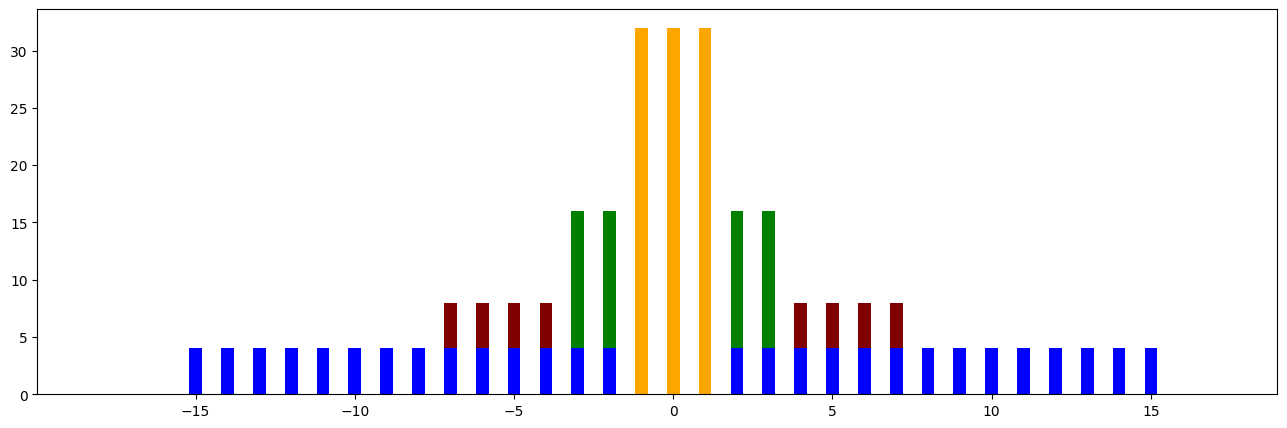

In [134]:
hist = {}
f8_fmts = ["e4m3","e3m4","e5m2","e2m5"]
color_tab = ['maroon','green','blue','orange']
x_range = np.arange(-18,18,step=1)
fig = plt.figure(figsize = (16, 5))

for i, idx in enumerate(f8_fmts):
   fmt = FloatNumber(idx)
   y_bins = {s:0 for s in x_range}
   for ridx in (fmt.get_range()):
      y_bins[ridx] = 2**fmt.get_float_mantissa()
   bins = [v for v in y_bins.values()]   
   plt.bar(x_range,bins,color=color_tab[i],label=fmt,width=0.4)
         



In [135]:
#Quantization- fundamentals

#quantize = convert real number to quantized number 
#dequantize convert a number from quantized number to a real number

#range mapping [Beta,alpha] be the range of representable real values 
#range mapping [qBeta,qalpha] be the range of representable of quantized values

# Affine quantization 
#  scale = 2**b -1  / (alpha-Beta)
#  zero-point = -round(Beta.scale) - 2**(b-1)
#  example int8 
#  scale = 255 / (alpha-beta)
#  zero  = -round(Beta* scale) - 128

#value clipping , quantized value will have a chance to be outside the range of [Qalpha,Qbeta]

# quantization with clipped value
# xq = clip(round(1/scale * x + z), [qalpha,qbeta])
# clip(xq,qalpha,qbeta) = qbeta if xq<qbeta , xq  qbeta>xq>qalpha qalpha if xq > qalpha

# de-quantization
# x = (1/s (xq - zero))

#scale quantization (-2**b-1 -1,  -2**b-1 -1 )  - ignore 2**b-1 
# scale = 2**b-1 -1 / alpha
# zero_point = 0
# xq = clip(x*s)

#scale de-quantization
#  x = (1/s * x)





In [136]:
class QuantTensor:
   """ 
   low precision Tensor (8,6,4 -bit tensor)
   """
   
   def __init__(
      self, num_bits, mantissa_bits, bias_value=None, max_val=None, QuantFunc=None):
   
     self.n_bits = num_bits
     self.mantissa_bits = mantissa_bits
     self.exp_bits = num_bits - self.mantissa_bits - 1
     self.bias_value  = 2 ** (self.exp_bits -1 ) -1 if bias_value is None else bias_value
   
     self.max_val = (2 - 2 ** (-self.mantissa_bits)) * 2 ** (2 ** self.exp_bits -1 - self.bias_value) if max_val is None else max_val
     self.QuantFunc = QuantFunc
   
   def set_maxval(self,maxval):
      self.max_val = maxval
      
   def set_range(self,x_min,x_max):
      self.max_val = abs(max(abs(x_min),abs(x_max)))
      
   def ret_maxval(self):
      return self.max_val
   
   def do_quant(self, input):
      result = self.QuantFunc(input,self.n_bits,self.mantissa_bits,self.max_val)
      return result
   
#check this one does this make sense? why we are using this 
def fpx_quantize(input, num_bits, mantissa_bits, max_val):
   
   M = np.clip(mantissa_bits,1,num_bits-1)
   E = num_bits - 1 - M
   
   #vectorize max_val to input shape
   if hasattr(max_val, "__len__"):
      if max_val.shape[0] != 1 and len(max_val.shape) != len(input.shape):
         max_val = max_val.view([-1] + [1]*(len(input.shape)-1))
   else:
      #print(f"maxval = {max_val}")
      maxval = np.full(input.shape,max_val,dtype=np.float64)
   
   #section 4.2 learned bias based on maxval
   Learnedbias = 2**E - np.log2(maxval) + np.log2(2 - 1/(2**(M))) - 1
   
   
   minval  = -maxval 
   x_float = np.fmin(np.fmax(input,minval),maxval)
   #section 4.1 Fp8 quantizer (generate integer scale (power of 2))
   log_scales = np.clip(np.floor(np.log2(np.abs(x_float))+Learnedbias),a_min=1.0,a_max=None)
   
   scale = 2.0 ** (log_scales-Learnedbias -M)
   result =  np.round((x_float/scale)) * scale
   return result  
 
def quantization(input, scale,zero_point,alpha_q,beta_q):
    x_q = np.round(1/scale * input + zero_point, decimals=0)
    x_q = np.clip(x_q, alpha_q,beta_q)
       
def dequantization(input, dtype_val, scale, zero_point):
    x   = scale*(input - zero_point)
    input = np.cast(x,dtype=dtype_val)
    return x
 
def generate_quantization_params(alpha,beta, alpha_q,beta_q):
   scale = (beta - alpha) / (beta_q - alpha_q)
   zero_point = int(beta * alpha_q - alpha*beta_q) / (beta - alpha)
   return scale, zero_point 
   


In [137]:
#Section 3 Quantization error
# analytical analysis of fp8 & int8 quantization error

# given quantization grid  Alpha = {alpha_1, alpha_2, alpha_3, alpha_4,.... alpha_k}
# quant-op for random variable W ~ pw(W) probability density function (uniform/gaussian/student)
# Q(W) = alpha(i)   i = argmin(w-alpha)
# Quant-error (R(W)) = Q(w) - W
# using MSE (mean-squared-error) for calculating quantization error
# MSE (Quant-error) = integral range [alpha_min , alpha_max] R(W) * RW  + integral range [-inf , alpha_min] (W-alpha_min**2 pw dw) + integral range [alpha_max , inf] (alpha_max - w)**2 pw dw
# where alpha_min = min(alpha(i)) alpha_max = max(alpha(i)) are the limits of quantization range

#  Quant-error = Rounding_error  + Clipping_Error

#1. rounding error
# Erw = integral_range[alpha_min,alpha_max] R(w)**2 p(w) dw 
# further simplify into two parts of error for each interval (alpha_i , alpha_i+1)
# Erw = integral_range[alpha_i, alpha_i+alpha_i+1/2] (w-alpha_i)**2 p(w) dw + integral_range[alpha_i+alpha_i+1/2 alpha_i+1] (alpha_i+1-w)**2 p(w) dw
#uniform distribution of values -5.0 to 5.0 
def uniform_dist_rne(alpha,beta,x0,p0):
    """ p0 = probability density function of uniform distribution for given input range"""
    first_term = (beta**3 - alpha**3) / 3.0 
    second_term = (alpha**2 - beta**2)*x0 
    third_term = (beta-alpha)*(x0**2)
    #print(f" alpha={alpha} beta={beta} input={x0}")
    #print(f" dist_rne : {p0,first_term, second_term, third_term}")
    return p0*(first_term + second_term + third_term)
    
def uniform_dist_cne(alpha,beta,x0,p0):
    first_term = p0*(alpha*alpha - beta*beta)/2 + p0*(beta-alpha)*x0
    return first_term

def Gaussian_dist_rne(gaussian_params:dict(),alpha,beta,input):
    
    """
    Params
    alpha,beta : limit range [a,b]
    gaussian_dict [mean, stdev, range_max,range_min] : mean and stddev , range_max, range_min of sample range of gaussian dist
    input : tensor (scalar)
    """
    
    mean = gaussian_params['mean']
    stdev = gaussian_params['stddev']      
    Z = 1/stdev*np.sqrt(2*np.pi)
    a_first_part =  -1*(np.exp((-1*(pow(alpha,2))/2 + alpha*mean - pow(mean,2)/2)/pow(stdev,2)) * pow(stdev,2) * (-1.0*alpha + -1.0*mean + 2*input))/Z
    a_second_part = -1*(np.sqrt(np.pi/2)*stdev*(-1 * pow(mean,2) + -1 * pow(stdev,2) + 2*mean*input + -1.0* pow(input,2))*sc.erf((-1*alpha + mean) / (stdev*np.sqrt(2))))/Z
    b_first_part = np.exp((-1*pow(beta,2)/2 + beta*mean + -1*pow(mean,2)/2) / pow(stdev,2))*pow(stdev,2)*(-1*beta + -1*mean+2*input)/Z 
    b_second_part = (np.sqrt(np.pi/2)*stdev*(-1 * pow(mean,2) + -1 * pow(stdev,2) + 2*mean*input + -1.0* pow(input,2))*sc.erf((-1*beta + mean) / (stdev*np.sqrt(2))))/Z
    return a_first_part + a_second_part + b_first_part + b_second_part


def clip(inp,range_min,range_max):
    return np.clip(inp, range_min, range_max)



def Gaussian_dist_cne(gaussian_params:dict(),alpha,beta,input):
    """
    Params
    alpha,beta : limit range [a,b]
    mean, stdev : mean and stddev sample range of gaussian dist
    input : tensor (scalar)
    """
    
    mean = gaussian_params['mean']
    stdev = gaussian_params['stddev']    
    
    Z = 1/(np.sqrt(stdev)*np.sqrt(2*np.pi))
    common_term = input*stdev*np.exp((-1*pow(mean,2)/(2*pow(stdev,2)))) / Z
    first_part =  common_term*np.exp(((-1*alpha/2 + mean)*alpha/pow(stdev,2)))
    second_part = common_term*np.exp(((-1*beta/2 + mean)*beta/pow(stdev,2)))*stdev + -1*np.sqrt(np.pi/2)*mean*(sc.erf((mean + -1.0 *alpha)/(np.sqrt(2)*stdev)) - sc.erf((beta+-1*mean)/(np.sqrt(2)*stdev)))
    third_part =  stdev/Z * np.exp((-1*pow(alpha,2)/2 + alpha*mean + -1*pow(mean,2)/2)/stdev) * stdev *(alpha+mean) + (np.sqrt(np.pi/2)*(pow(mean,2) - pow(stdev,2))*sc.erf((mean-alpha)/(np.sqrt(2)*stdev)))
    fourth_part = stdev/Z * np.exp((-1*pow(beta,2)/2 + alpha*mean + -1*pow(mean,2)/2)/stdev) * stdev *(beta+mean) + (np.sqrt(np.pi/2)*(pow(mean,2) - pow(stdev,2))*sc.erf((mean-beta)/(np.sqrt(2)*stdev)))
    return (first_part - second_part - third_part +  fourth_part)

def integration(range,inp,diff):
    start_limit = range[0]
    end_limit = range[1]
    return np.sum(inp**(start_limit-1) * (1-inp)**(end_limit-1) * diff)

def studentT_betafn(degree_freedom):
    '''uses gamma function or inbuilt math.gamma() to compute values of beta function'''
    """ source wikipedia https://en.wikipedia.org/wiki/Student%27s_t-distribution """
    
    beta = math.gamma(degree_freedom*0.5 + 0.5) / ((np.sqrt(np.pi*degree_freedom)) * math.gamma(degree_freedom*0.5))
    return beta

    

def studentT_dist_rne(alpha,beta,input,degree_of_freedom=2):
    inverse_Z = studentT_betafn(degree_of_freedom) 
    common_denom = (1 + -1.0*degree_of_freedom)
    #paper appendix section have these equations printed wrongly, power of (-1 + a**2+degree_of_freedom/degree_of_freedom) gives large error value
    a_first_part = 2.0*degree_of_freedom*input*(-1 + pow(((pow(alpha,2)+degree_of_freedom)/degree_of_freedom),(0.5 + -0.5*degree_of_freedom))) 
    b_first_part = 2.0*degree_of_freedom*input*(-1 + pow(((pow(beta, 2)+degree_of_freedom)/degree_of_freedom),(0.5 + -0.5*degree_of_freedom)))
    first_part = (a_first_part + -1.0*b_first_part)*(1/common_denom)

    a_second_part = -1.0 * alpha * pow(input,2) * sc.hyp2f1(0.5,(1+degree_of_freedom)/2, 1.5, -1*pow(alpha,2)/degree_of_freedom)
    b_second_part = beta * pow(input,2) * sc.hyp2f1(0.5,(1+degree_of_freedom)/2, 1.5, -1*pow(beta,2)/degree_of_freedom)
    second_part = (a_second_part + b_second_part)

    a_third_part = -1.0*pow(alpha,3) * sc.hyp2f1(1.5,(1+degree_of_freedom)/2, 2.5, -1.0*pow(alpha,2)/degree_of_freedom)
    b_third_part = pow(beta,3) * sc.hyp2f1(1.5,(1+degree_of_freedom)/2, 2.5, -1.0*pow(beta,2)/degree_of_freedom)
    third_part = (a_third_part + b_third_part)*(1/3)

    return (first_part + second_part + third_part)*inverse_Z

def studentT_dist_cne(alpha,beta,input,degree_of_freedom=2):
    
    inverse_Z = studentT_betafn(degree_of_freedom)
    common_term = pow(degree_of_freedom,(1+degree_of_freedom)*0.5)*input/(1-degree_of_freedom)
    first_term = pow((pow(alpha,2)+ degree_of_freedom),(1 + -1.0*degree_of_freedom)*0.5)
    second_term = pow((pow(beta,2)+ degree_of_freedom),(1 + -1.0*degree_of_freedom)*0.5)
    third_term = studentT_dist_rne(alpha,beta,0,degree_of_freedom)

    return ((second_term - first_term) * inverse_Z *common_term + third_term)


def UniformClipError(quant_min,quant_max,input_min,input_max,input):
    #if input_min < quant_min:
    #input_min < quant_min is always true for cases higher precision to lower precision.
    first_part = uniform_dist_cne(quant_min,input_min,quant_min,input)
    #else:
    #first_part = 0.0
    second_part = uniform_dist_cne(input_max,quant_max,quant_max,input)
    return first_part + second_part

def QuantError(input,QuantRange,input_range):
    QuantError = 0.0
    quant_min = QuantRange[0]
    quant_max = QuantRange[-1]
    for range,range_i in zip(QuantRange,QuantRange[1:]):
        RoundError = RoundError(range,range_i,input)
        ClipError  = clipping_error(quant_min,quant_max,input_range[0],input_range[1],input)
        QuantError += RoundError+ClipError
    return QuantError

def UniformRoundError(QuantRange, input_range):
    RError = 0.0
    range_min = input_range[0]
    range_max = input_range[1]
    
    p0 = 1/(range_max-range_min)
    
    if range_min < QuantRange[0]:
        RError += uniform_dist_rne(range_min,QuantRange[0],QuantRange[0],p0)
        
    for range,range_i in zip(QuantRange,QuantRange[1:]):
        
        mid_point = (range+range_i)/2
        a = max(range_min,range)
        b = min(mid_point, range_max)
        first_part = uniform_dist_rne(a,b,range,p0) if a < b else  0.0
        a = max(mid_point, range_min)
        b = min(range_i,range_max)
        second_part = uniform_dist_rne(a,b,range_i,p0) if a < b else 0.0
        RError += first_part + second_part
        #print(f" range {range}  range_i {range_i} res={RError}")
    if range_max > QuantRange[-1]:
        RError += uniform_dist_rne(QuantRange[-1],range_max, QuantRange[-1],p0)  
    
    return RError

def UniformClippingError(QuantRange, input_range):
    CError = 0.0
    range_min = input_range[0]
    range_max = input_range[1]
    
    p0 = 1/(range_max-range_min)
    
    if range_min < QuantRange[0]:
        CError += uniform_dist_cne(range_min,QuantRange[0],QuantRange[0],p0)

    for range,range_i in zip(QuantRange,QuantRange[1:]):
        
        mid_point = (range+range_i)/2
        a = max(range_min,range)
        b = min(mid_point, range_max)
        first_part = uniform_dist_cne(a,b,range,p0) if a < b else 0.0

        a = max(mid_point, range_min)
        b = min(range_i,range_max) if a < b else 0.0
        second_part = uniform_dist_cne(a,b,range_i,p0)
    
        CError += first_part + second_part
    if range_max > QuantRange[-1]:
        CError += uniform_dist_cne(QuantRange[-1],range_max, QuantRange[-1],p0)  
    
    return CError

def GaussianRoundError(gaussian_params:dict(),QuantRange, input_range):
    RError = 0.0
    range_min = input_range[0]
    range_max = input_range[1]
    

    if range_min < QuantRange[0]:
        RError += Gaussian_dist_rne(gaussian_params,range_min,QuantRange[0],QuantRange[0])
    
    for range,range_i in zip(QuantRange,QuantRange[1:]):
        
        mid_point = (range+range_i)/2
        a = max(range_min,range)
        b = min(mid_point, range_max)
        first_part = Gaussian_dist_rne(gaussian_params,a,b,range) if a < b else 0.0
        a = max(mid_point, range_min)
        b = min(range_i,range_max)
        second_part = Gaussian_dist_rne(gaussian_params,a,b,range_i) if a < b else 0.0
        RError += first_part + second_part
        #print(f" range {range}  range_i {range_i} res={RError}")
    if range_max > QuantRange[-1]:
        RError += Gaussian_dist_rne(gaussian_params,QuantRange[-1],range_max, QuantRange[-1])  
        
    return RError

def GaussianClippingError(gaussian_params:dict(),QuantRange, input_range):
    CError = 0.0
    range_min = input_range[0]
    range_max = input_range[1]
    

    if range_min < QuantRange[0]:
        CError += Gaussian_dist_cne(gaussian_params,range_min,QuantRange[0],QuantRange[0])
    
    for range,range_i in zip(QuantRange,QuantRange[1:]):
        
        mid_point = (range+range_i)/2
        a = max(range_min,range)
        b = min(mid_point, range_max)
        first_part = Gaussian_dist_cne(gaussian_params,a,b,range) if a < b else 0.0
        a = max(mid_point, range_min)
        b = min(range_i,range_max)
        second_part = Gaussian_dist_cne(gaussian_params,a,b,range_i) if a < b else 0.0
        CError += first_part + second_part
    if range_max > QuantRange[-1]:
        CError += Gaussian_dist_cne(gaussian_params,QuantRange[-1],range_max, QuantRange[-1])  
        
    return CError

def StudentTRoundError(QuantRange, input_range,degree_of_freedom=2):
    RError = 0.0
    range_min = input_range[0]
    range_max = input_range[1]
    
    p0 = 1/(range_max-range_min)
    
    if range_min < QuantRange[0]:
        RError += studentT_dist_rne(range_min,QuantRange[0],QuantRange[0],degree_of_freedom)
    
    for range,range_i in zip(QuantRange,QuantRange[1:]):
        
        mid_point = (range+range_i)/2
        a = max(range_min,range)
        b = min(mid_point, range_max)
        first_part = studentT_dist_rne(a,b,range,degree_of_freedom) if a < b else 0.0
        a = max(mid_point, range_min)
        b = min(range_i,range_max)
        second_part = studentT_dist_rne(a,b,range_i,degree_of_freedom) if a < b else 0.0
        RError += first_part + second_part
        #print(f" range {range}  range_i {range_i} res={RError}")
    if range_max > QuantRange[-1]:
        RError += studentT_dist_rne(QuantRange[-1],range_max, QuantRange[-1],degree_of_freedom)  
        
    return RError

def StudentTClippingError(QuantRange, input_range,degree_of_freedom=2):
    CError = 0.0
    range_min = input_range[0]
    range_max = input_range[1]
    
    p0 = 1/(range_max-range_min)
    
    if range_min < QuantRange[0]:
        CError += studentT_dist_cne(range_min,QuantRange[0],QuantRange[0],degree_of_freedom)
    
    for range,range_i in zip(QuantRange,QuantRange[1:]):
        
        mid_point = (range+range_i)/2
        a = max(range_min,range)
        b = min(mid_point, range_max)
        first_part = studentT_dist_cne(a,b,range,degree_of_freedom) if a < b else 0.0
        a = max(mid_point, range_min)
        b = min(range_i,range_max)
        second_part = studentT_dist_cne(a,b,range_i,degree_of_freedom) if a < b else 0.0
        CError += first_part + second_part
    if range_max > QuantRange[-1]:
        CError += studentT_dist_cne(QuantRange[-1],range_max, QuantRange[-1],degree_of_freedom)  
        
    return CError


#function to find  Quant range for given distribution. range helps to adjust bias and scale value for quant step
def find_min_max(data,num_samples=100,quant_scheme=None,Quantizer=None):
    #current_max
    num_channels = len(data) if quant_scheme == "per-channel" else 1
    xmax = np.zeros(num_channels,dtype=np.float32)
    xmin = np.zeros(num_channels, dtype = np.float32)
    
    loss = np.zeros((num_channels,num_samples+1))
    loss[:,0] = np.inf
    max_pos_value = max(abs(float(data.min())),abs(float(data.max())))
    min_neg_value = -1 * max_pos_value * 20  #(scale up 20x range (min,max))
    max_number_range = max_pos_value * 20
    #step value calculated by taking data.max and dividing by number of samples , providing per step value of input data
    #the step value helps to find closest Quant value for given input.
    step_val = max_number_range/num_samples
    data_min_gt_eq_0 = (data.min() >= 0)
    for idx in range(1,num_samples+1):
        neg_value = 0 if data_min_gt_eq_0 else -1.0*step_val*idx
        pos_value = step_val*idx
        #MSE_LOSS
        #quantize input data
        Quantize = copy.deepcopy(Quantizer)
        Quantize.set_range(neg_value,pos_value)
        QuantData = Quantize.do_quant(data)
        loss_value = np.reshape(((QuantData-data) ** 2),(len(data), -1))
        loss_sum = np.sum(loss_value,axis=1)
        loss_ = np.sum(loss_sum)
        #print(f"loss_value={loss_}")
        loss[:,idx] += loss_ 
    min_idx = np.argmin(loss,axis=1)
    data_min_gt_eq_0 = (data.min() >= 0)
    xmin = (0 if data_min_gt_eq_0  else (-1*step_val * min_idx)).astype(float)
    xmax = (step_val*min_idx).astype(float)
    return(xmin,xmax)       


        

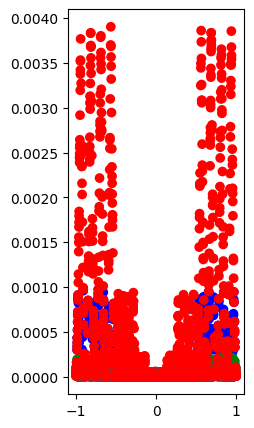

In [138]:
seed = 10
np.random.seed(seed)
random.seed(seed)
uniform_range_min = -1.0
uniform_range_max = 1.0
num_samples = 1000

input = np.random.uniform(uniform_range_min,uniform_range_max,num_samples)
plt.figure(figsize=(5,5))
colors = ['blue','green','brown','red']
for idx,fmt in enumerate(["e4m3","e3m4","e2m5","e5m2"]):
  QuantNumber = FloatNumber(fmt)
  grids = QuantNumber.get_grids()

  QuantVal = []
  RoundingError = []
  for inp in (input):
    Quant_val = inp
    min_val = 65536
    for grid in grids:
        min_val,Quant_val = (abs(inp-grid),grid) if abs(inp-grid) < min_val else (min_val,Quant_val) 
    #print(f"min_val {min_val} Quant_val={Quant_val} grid={grid}")    
    RError = ((Quant_val - inp)**2)
    RoundingError.append(RError)
  color = [colors[idx]]*len(RoundingError)
  plt.subplot(121)
  plt.scatter(input,RoundingError,c=color)




In [139]:
#utility function

def print_grids_columns(grids):
    for a,b,c,d,e,f,g,h in zip(grids[::8],grids[1::8],grids[2::8],grids[3::8],grids[4::8],grids[5::8],grids[6::8],grids[7::8]):
        print('{:<7}{:<7}{:<7}{:<7}{:<7}{:<7}{:<7}{:<7}'.format(a,b,c,d,e,f,g,h))

In [148]:
seed = 10
np.random.seed(seed)
random.seed(seed)


#uniform distribution RoundError

distribution = dict()
distribution = {'uniformDistr' : UniformRoundError, 'GaussianDistr': GaussianRoundError, 'StudentTDistr' : StudentTRoundError}
distr_range_min = -1.0
distr_range_max = 1.0
num_samples = 5000
input = np.random.uniform(distr_range_min,distr_range_max,num_samples)
input_range = (distr_range_min,distr_range_max)

QuantSqnr = [[],[],[],[],[]]

for idx,fmt in enumerate(["e2m5","e3m4","e4m3","e5m2"]):
   QuantNumber = FloatNumber(fmt)
   grids = QuantNumber.get_grids()
   bias_value = QuantNumber.get_float_bias()
   mantissa_bits = QuantNumber.get_float_mantissa()
   Quantizer = QuantTensor(num_bits=8,mantissa_bits=mantissa_bits,bias_value=bias_value,QuantFunc=fpx_quantize)
   Quant_min,Quant_max =  find_min_max(input,num_samples=100,Quantizer=Quantizer)
   #print(f" QuantMin,QuantMax = {Quant_min,Quant_max}")
   Quantizer.set_range(Quant_min,Quant_max)
   #scale 'grid' with grid * range.(max-min) / grid.(max-min)
   max_val = np.max(np.abs(grids)).astype(float)
   scaled_max_val = (max_val/Quant_max)
   ScaledGrid = (grids / scaled_max_val).astype(float)
   Quanterror = UniformRoundError(ScaledGrid,input_range)
   quant_sqnr = -10.0*np.log10((Quanterror))
   QuantSqnr[idx].append(quant_sqnr)
   print(f"fp8_format={fmt} RoundError {Quanterror} Signal2NoiseRatio={quant_sqnr}")



#empirical rounding error for quantization grids


fp8_format=e2m5 RoundError 1.1997010612113016e-05 Signal2NoiseRatio=49.20926956985768
fp8_format=e3m4 RoundError 4.628440964978167e-05 Signal2NoiseRatio=43.34565271255801
fp8_format=e4m3 RoundError 0.00017945297112255496 Signal2NoiseRatio=37.460493468517846
fp8_format=e5m2 RoundError 0.0006786606603150666 Signal2NoiseRatio=31.68347324675127


In [149]:

distr_range_min = -5.0
distr_range_max = 5.0
gaussian_params = {}
gaussian_params['mean'] = 0
gaussian_params['stddev'] = 1.0
num_samples = 5000
input = np.random.normal(loc=gaussian_params['mean'],scale=gaussian_params['stddev'],size=num_samples)
input_range = (distr_range_min,distr_range_max)

for idx,fmt in enumerate(["e2m5","e3m4","e4m3","e5m2"]):
#for idx,fmt in enumerate(["e2m5"]):
   QuantNumber = FloatNumber(fmt)
   grids = QuantNumber.get_grids()
   bias_value = QuantNumber.get_float_bias()
   mantissa_bits = QuantNumber.get_float_mantissa()
   Quantizer = QuantTensor(num_bits=8,mantissa_bits=mantissa_bits,bias_value=bias_value,QuantFunc=fpx_quantize)
   Quant_min,Quant_max =  find_min_max(input,num_samples=100,Quantizer=Quantizer)
   #print(f"{Quant_min,Quant_max}")
   Quantizer.set_range(Quant_min,Quant_max)
   #scale 'grid' with grid * range.(max-min) / grid.(max-min)
   max_val = np.max(np.abs(grids)).astype(float)
   scaled_max_val = (max_val/Quant_max)
   ScaledGrid = (grids / scaled_max_val).astype(float)
   Quanterror = GaussianRoundError(gaussian_params,ScaledGrid,input_range)
   quant_sqnr = -10.0*np.log10((Quanterror))
   QuantSqnr[idx].append(quant_sqnr)
   print(f"fp8_format={fmt} RoundError {Quanterror} Signal2NoiseRatio={quant_sqnr}")


fp8_format=e2m5 RoundError 7.293041507061213e-05 Signal2NoiseRatio=41.370913147194166
fp8_format=e3m4 RoundError 0.00017556387298469007 Signal2NoiseRatio=37.55564847072186
fp8_format=e4m3 RoundError 0.0007051318721686677 Signal2NoiseRatio=31.517296546405795
fp8_format=e5m2 RoundError 0.002777686475155504 Signal2NoiseRatio=25.563167758029046


In [150]:
distr_range_min = -100.0
distr_range_max = 100.0
num_samples = 5000

for df in [2,8]:
   input = np.random.standard_t(df=df,size=num_samples)
   input = np.clip(input,distr_range_min,distr_range_max)
   input_range = (distr_range_min,distr_range_max)
   for idx,fmt in enumerate(["e2m5","e3m4","e4m3","e5m2"]):
      QuantNumber = FloatNumber(fmt)
      grids = QuantNumber.get_grids()
      bias_value = QuantNumber.get_float_bias()
      mantissa_bits = QuantNumber.get_float_mantissa()
      Quantizer = QuantTensor(num_bits=8,mantissa_bits=mantissa_bits,bias_value=bias_value,QuantFunc=fpx_quantize)
      Quant_min,Quant_max =  find_min_max(input,num_samples=100,Quantizer=Quantizer)
      #print(f"{Quant_min,Quant_max}")
      Quantizer.set_range(Quant_min,Quant_max)
      #scale 'grid' with grid * range.(max-min) / grid.(max-min)
      max_val = np.max(np.abs(grids)).astype(float)
      scaled_max_val = (max_val/Quant_max)
      ScaledGrid = (grids / scaled_max_val).astype(float)
      Quanterror = StudentTRoundError(ScaledGrid,input_range,df)
      quant_sqnr = -10.0*np.log10((Quanterror))
      QuantSqnr[idx].append(quant_sqnr)
      print(f" degree_of_freedom = {df} fp8_format={fmt} RoundError {Quanterror} Signal2NoiseRatio={quant_sqnr}")





 degree_of_freedom = 2 fp8_format=e2m5 RoundError 0.020220034558584114 Signal2NoiseRatio=16.9421810648045
 degree_of_freedom = 2 fp8_format=e3m4 RoundError 0.014030740605398904 Signal2NoiseRatio=18.52919404356598
 degree_of_freedom = 2 fp8_format=e4m3 RoundError 0.0055061513894749045 Signal2NoiseRatio=22.591518520219278
 degree_of_freedom = 2 fp8_format=e5m2 RoundError 0.021519946237007682 Signal2NoiseRatio=16.671588179963575
 degree_of_freedom = 8 fp8_format=e2m5 RoundError 0.0023374218081367196 Signal2NoiseRatio=26.312629083111606
 degree_of_freedom = 8 fp8_format=e3m4 RoundError 0.00024037297594085348 Signal2NoiseRatio=36.191143597120465
 degree_of_freedom = 8 fp8_format=e4m3 RoundError 0.0009361948267593375 Signal2NoiseRatio=30.286337630334867
 degree_of_freedom = 8 fp8_format=e5m2 RoundError 0.003707749819769906 Signal2NoiseRatio=24.308895775369713


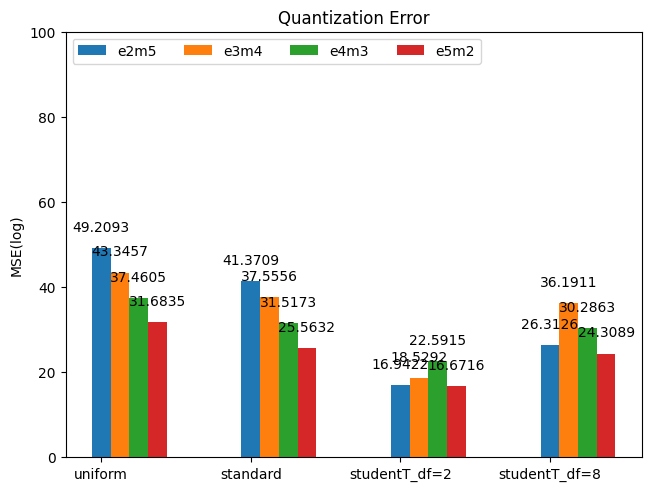

In [151]:
import numpy as np
import matplotlib.pyplot as plt 

distribution = ("uniform","standard","studentT_df=2","studentT_df=8")
fp8_variants = {
        'e2m5' : tuple(QuantSqnr[0]),
        'e3m4' : tuple(QuantSqnr[1]),
        'e4m3' : (QuantSqnr[2]),
        'e5m2' : (QuantSqnr[3]),
}

x = np.arange(len(distribution))
width = 0.125
multiplier = 0


fig,ax = plt.subplots(layout = 'constrained')

for attr,mea in fp8_variants.items():
        offset = width*multiplier
        rects = ax.bar(x+offset,mea,width,label=attr)
        ax.bar_label(rects,padding=10)
        multiplier +=1

ax.set_xticks(x,distribution)
ax.set_ylabel("MSE(log)")
ax.set_title("Quantization Error")
ax.legend(loc='upper left',ncols=4)
ax.set_ylim(0,100)

plt.show()